In [1]:
#my modules
import wrangle as wr
import explore as ex
import model as m

#Imports
import pandas as pd
import numpy as np

import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

imports loaded successfully, awaiting commands...


In [2]:
pd.set_option("display.max_colwidth", 250)

In [3]:
df = pd.read_parquet('df_prep.parquet')

In [4]:
df.company_response_to_consumer.value_counts()

Closed with explanation            982289
Closed with non-monetary relief    205284
Closed with monetary relief         50963
Untimely response                    4459
Closed                               3741
Name: company_response_to_consumer, dtype: int64

In [5]:
relief = ['Closed with monetary relief', 'Closed with non-monetary relief']
no_relief = ['Closed with explanation']
df = df[df['company_response_to_consumer'] != "Untimely response"]
df = df[df['company_response_to_consumer'] != "Closed"]

In [6]:
df['response'] = np.where(df['company_response_to_consumer'].isin(relief),'relief','')
df['response'] = np.where(df['company_response_to_consumer'].isin(no_relief),'no_relief',df['response'])

In [7]:
df = df.drop(columns='company_response_to_consumer')

In [8]:
df.response.value_counts(normalize=True)

no_relief    0.793105
relief       0.206895
Name: response, dtype: float64

In [63]:
baseline_accuracy = round(('no_relief' == df.response).mean(),4) * 100
print(f'Baseline Accuracy is {baseline_accuracy}%')

Baseline Accuracy is 79.31%


In [9]:
df.response.value_counts()

no_relief    982289
relief       256247
Name: response, dtype: int64

Specificity: When the actual value is negative, how often is the prediction correct?

* Something we want to maximize
* How "specific" (or "selective") is the classifier in predicting positive instances?
* TN / all negative
    * all negative = TN + FP
    
False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [10]:
# split
train, val, test = wr.split_data(df, 'response')

Prepared DF: (1238536, 8)
Train: (743121, 8)
Validate: (247707, 8)
Test: (247708, 8)


In [11]:
train.head(1)

,date_received,company_name,state,tags,product_bins,clean,lemon,response
274292,2019-09-09,Experian Information Solutions Inc.,FL,Servicemember,credit_report,i have been a victim of id theft and have submitted documentation to the credit bureaus and they are refusing to abide by fcra b pertaining to my request the original creditor has no proof other than statements and i have constantly refuted this ...,victim id theft submitted documentation credit bureau refusing abide fcra b pertaining request original creditor proof statement constantly refuted charge submitting proof id theft claim reporting complaint credit bureau consistent harm financial...,relief


In [12]:
def encode(df):
    '''Encode categorical columns'''
    # columns to encode
    cols = ['tags','product_bins']
    # encode the dummies
    dummy = pd.get_dummies(df[cols],prefix='',prefix_sep='',drop_first=True)
    # bring the dummies along
    return pd.concat([df,dummy],axis=1)


def process_data_modeling(train, validate, test):
    """
    The function `process_data_modeling` reads data from parquet files, performs data sampling,
    encoding, and splits the data into training, validation, and test sets.
    
    :param train: The `train` parameter is the training dataset, which is a pandas DataFrame containing
    the data for training the model
    :param validate: The `validate` parameter is a DataFrame that contains the validation data. It is
    read from a parquet file named 'validate.parquet'
    :param test: The `test` parameter is a DataFrame that contains the test data for your model. It is
    read from a parquet file named 'test.parquet'
    :return: six variables: X_train, y_train, X_val, y_val, X_test, and y_test.
    """
    random_state = 123
    response_categories = [
        'relief',
        'no_relief'
    ]

    sm_train = []
    sm_val = []
    sm_test = []

    small_train = pd.DataFrame()
    small_val = pd.DataFrame()
    small_test = pd.DataFrame()

    random_state = 123
    percent = .2

    for category in response_categories:
        sm_train.append(int(round(len(train[train.response == category]) * percent, 0)))
        sm_val.append(int(round(len(validate[validate.response == category]) * percent, 0)))
        sm_test.append(int(round(len(test[test.response == category]) * percent, 0)))
        
        small_train = small_train.append(train[train.response == category].sample(sm_train[-1], random_state=random_state))
        small_val = small_val.append(validate[validate.response == category].sample(sm_val[-1], random_state=random_state))
        small_test = small_test.append(test[test.response == category].sample(sm_test[-1], random_state=random_state))

    small_train.reset_index(drop=True, inplace=True)
    small_val.reset_index(drop=True, inplace=True)
    small_test.reset_index(drop=True, inplace=True)

    X_train = encode(small_train)
    X_train = X_train.drop(columns=['date_received','clean','state','company_name','tags','product_bins', 'response'])
    y_train = small_train['response']
    X_val = encode(small_val)
    X_val = X_val.drop(columns=['date_received','clean','state','company_name','tags','product_bins', 'response'])
    y_val = small_val['response']
    X_test = encode(small_test)
    X_test = X_test.drop(columns=['date_received', 'clean','state','company_name','tags','product_bins', 'response'])
    y_test = small_test['response']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
# X_train, etc...
X_train, y_train, X_val, y_val, X_test, y_test = process_data_modeling(train, val, test)

In [14]:
# vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, recall_score, average_precision_score, precision_score

In [34]:
def make_mbt_tfidf(Xtr,Xv,Xt):
    """
    The function `make_tfidf` takes in three sets of data (train, validation, and test) and applies the
    TF-IDF vectorization technique to convert the text data into numerical features, using n-grams up to
    trigrams and keeping single characters. It then returns the transformed data as pandas DataFrames.
    
    :param Xtr: Xtr is the training data, which is a dataframe containing the text data that you want to
    transform into TF-IDF features. The "lemmatized" column in the dataframe contains the preprocessed
    text data
    :param Xv: Xv is the validation dataset, which is used to evaluate the performance of the model
    during training
    :param Xt: Xt is the input data for the test set. It is a dataframe containing the text data that
    needs to be transformed into TF-IDF representation
    :return: three dataframes: Xtr_tfidf, Xv_tfidf, and Xt_tfidf.
    """
    #make my bag of words up to trigrams tfidf and keep single characters
    tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b',lowercase=False, max_features=2900, ngram_range=(1,3))
    # fit and transform train
    Xtr_bow_tfidf = tfidf.fit_transform(Xtr.lemon.astype(str))
    # transform val and test
    Xv_bow_tfidf = tfidf.transform(Xv.lemon.astype(str))
    Xt_bow_tfidf = tfidf.transform(Xt.lemon.astype(str))
    # make dfs
    Xtr_tfidf = pd.DataFrame(Xtr_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xtr.index)
    Xv_tfidf = pd.DataFrame(Xv_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xv.index)
    Xt_tfidf = pd.DataFrame(Xt_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xt.index)
    return Xtr_tfidf,Xv_tfidf,Xt_tfidf

def process_vector_merge(X_train,X_val,X_test):
    X_train_tf, X_val_tf, X_test_tf = make_mbt_tfidf(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])
    
    encoded_train = X_train.iloc[:, 1:]
    encoded_val = X_val.iloc[:, 1:]
    encoded_test = X_test.iloc[:, 1:]
    
    X_train_tfe = encoded_train.merge(X_train_tf, left_index=True, right_index=True)
    X_val_tfe = encoded_val.merge(X_val_tf, left_index=True, right_index=True)
    X_test_tfe = encoded_test.merge(X_test_tf, left_index=True, right_index=True)
    
    # Visualization of train data
    return X_train_tfe, X_val_tfe, X_test_tfe

In [35]:
# vectorize
X_train_tfe, X_val_tfe, X_test_tfe = process_vector_merge(X_train,X_val,X_test)
X_train_tfe

,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage_x,ability,...,year u,year u c,yes,yesterday,yet,yet feel,yet feel like,yet receive,yr,zero
0,0,0,1,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148620,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148621,0,0,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148622,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148623,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# make
dt = DecisionTreeClassifier(random_state=123, max_depth=10, max_leaf_nodes=10)

# fit
dt.fit(X_train_tfe, y_train)

# use
dt_train = dt.score(X_train_tfe, y_train)
dt_val = dt.score(X_val_tfe, y_val)
print(f'Baseline Accuracy is {baseline_accuracy}%')
print(f"Train Accuracy: {dt_train:.3}%")
print(f"Validate Accuracy: {dt_val:.3}%")
print()

#predict
dt_pred_train = dt.predict(X_train_tfe)
dt_pred_val = dt.predict(X_val_tfe)

# recall score
r_score_train = recall_score(y_train, dt_pred_train, pos_label='no_relief')
r_score_val = recall_score(y_val, dt_pred_val, pos_label='no_relief')
print(f"Train recall score: {r_score_train:.3}%")
print(f"Validate recall score: {r_score_val:.3}%")

Baseline Accuracy is 79.31%
Train Accuracy: 0.795%
Validate Accuracy: 0.795%

Train recall score: 0.997%
Validate recall score: 0.997%


In [82]:
# classification report for train
round(pd.DataFrame(classification_report(y_train, dt_pred_train, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.800,0.638,0.797,0.719,0.766
recall,0.993,0.046,0.797,0.520,0.797
f1-score,0.886,0.086,0.797,0.486,0.720
support,117875.000,30750.000,0.797,148625.000,148625.000


In [83]:
# classification report for validate
round(pd.DataFrame(classification_report(y_val, dt_pred_val, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.799,0.613,0.797,0.706,0.761
recall,0.993,0.045,0.797,0.519,0.797
f1-score,0.886,0.085,0.797,0.485,0.720
support,39292.000,10250.000,0.797,49542.000,49542.000


In [93]:
def classifier_tree_eval(X_train, y_train, X_validate, y_validate, baseline_accuracy):
    ''' This function is to calculate the best classifier decision tree model by running 
    a for loop to explore the max depth per default range (1,20).

    The loop then makes a list of lists of all max depth calculations, compares the
    accuracy between train and validate sets, turns to df, and adds a new column named
    difference. The function then calculates the baseline accuracy and plots the
    baseline, and the train and validate sets to identify where overfitting occurs.
    '''
    scores_all=[]

    for x in range(1,11):
        tree = DecisionTreeClassifier(max_depth=x, random_state=123)
        tree.fit(X_train, y_train)
        train_acc = tree.score(X_train, y_train)
        print(f"For depth of {x}, the train accuracy is {round(train_acc,3)}")
        
        # evaludate on validate set
        validate_acc = tree.score(X_validate, y_validate)
        print(f"For depth of {x}, the validate accuracy is {round(validate_acc,3)}")
        
        # recall score
        r_score_train = recall_score(y_train, dt_pred_train, pos_label='no_relief')
        r_score_val = recall_score(y_val, dt_pred_val, pos_label='no_relief')
        print(f"Train recall score: {r_score_train:.3}%")
        print(f"Validate recall score: {r_score_val:.3}%")
        print()

        # append to df scores_all
        scores_all.append([x, train_acc, validate_acc])

        # turn to df
        scores_df = pd.DataFrame(scores_all, columns=['max_depth', 'train_acc', 'validate_acc'])

        # make new column
        scores_df['difference'] = scores_df.train_acc - scores_df.validate_acc

        # sort on difference
        scores_df.sort_values('difference')


    # plot to visulaize
    plt.figure(figsize=(12,8))
    plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
    plt.plot(scores_df.max_depth, scores_df.validate_acc, label='validate', marker='o')
    plt.axhline(baseline_accuracy, linewidth=2, color='black', label='baseline')
    plt.xlabel('Max Depth for Decision Tree')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,11, step=1))
    plt.title('Where do I begin to overfit?')
    plt.legend()
    plt.show()

For depth of 1, the train accuracy is 0.793
For depth of 1, the validate accuracy is 0.793
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 2, the train accuracy is 0.793
For depth of 2, the validate accuracy is 0.793
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 3, the train accuracy is 0.795
For depth of 3, the validate accuracy is 0.795
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 4, the train accuracy is 0.795
For depth of 4, the validate accuracy is 0.795
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 5, the train accuracy is 0.797
For depth of 5, the validate accuracy is 0.795
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 6, the train accuracy is 0.798
For depth of 6, the validate accuracy is 0.796
Train recall score: 0.993%
Validate recall score: 0.993%

For depth of 7, the train accuracy is 0.8
For depth of 7, the validate accuracy is 0.797
Train recall scor

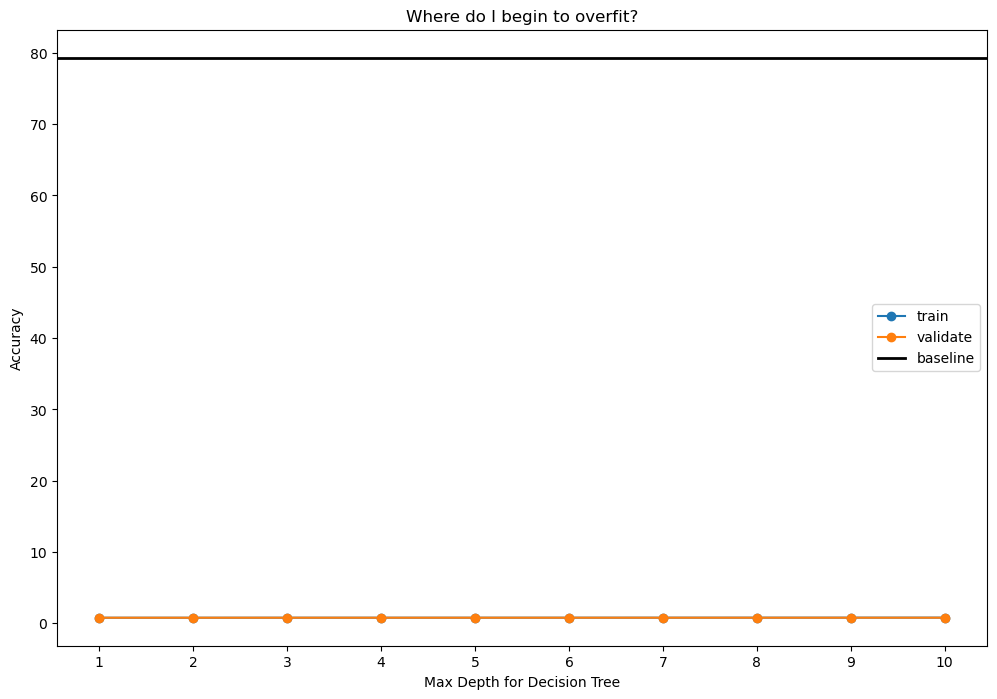

In [94]:
classifier_tree_eval(X_train_tfe, y_train, X_val_tfe, y_val, baseline_accuracy)

In [39]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plot 
import matplotlib.pyplot as plt

In [40]:
# make
lr = LogisticRegression(random_state=123)

# fit model
lr.fit(X_train_tfe, y_train)

# use
lr_train = lr.score(X_train_tfe, y_train)
lr_val = lr.score(X_val_tfe, y_val)
print(f'Baseline Accuracy is {baseline_accuracy}%')
print(f"Train Accuracy: {lr_train:.3}%")
print(f"Validate Accuracy: {lr_val:.3}%")
print()

# predictions
y_pred_train = lr.predict(X_train_tfe)
y_pred_val = lr.predict(X_val_tfe)

# recall score
r_score_train = recall_score(y_train, y_pred_train, pos_label='no_relief')
r_score_val = recall_score(y_val, y_pred_val, pos_label='no_relief')
print(f"Train recall score: {r_score_train:.3}%")
print(f"Validate recall score: {r_score_val:.3}%")

Train Accuracy: 0.8%
Validate Accuracy: 0.797%
Train recall score: 0.981%
Validate recall score: 0.979%


In [41]:
# classification report for train
round(pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.808,0.589,0.8,0.699,0.763
recall,0.981,0.106,0.8,0.543,0.800
f1-score,0.886,0.180,0.8,0.533,0.740
support,117875.000,30750.000,0.8,148625.000,148625.000


In [42]:
# classification report for validate
round(pd.DataFrame(classification_report(y_val, y_pred_val, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.807,0.557,0.797,0.682,0.755
recall,0.979,0.100,0.797,0.540,0.797
f1-score,0.885,0.170,0.797,0.527,0.737
support,39292.000,10250.000,0.797,49542.000,49542.000


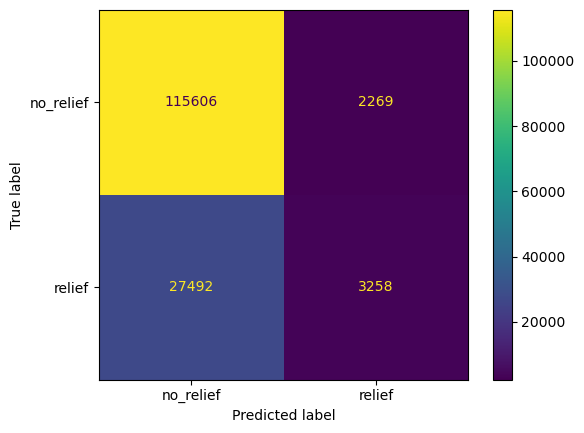

In [43]:
# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train, labels=lr.classes_), display_labels=lr.classes_).plot()
plt.show()

In [47]:
# numbers for 10000 features
# establish TN, TP, FP, FN

# TN = 4433
# TP = 115203
# FP = 2672
# FN = 26317

# numbers for 2900 features
# establish TN, TP, FP, FN

TN = 3258
TP = 115606
FP = 2269
FN = 27492

In [48]:
# specificity
specificity = TN / (TN + FP)

print(specificity)

0.5894698751583137


minimizing damage by looking at additional metrics on top of accuracy baseline which is an average. Slightly improved on baseline but where we really saw the benefit was looking at the recall score which states predicts relief - no relief given.

98% good at catching false negatives. The times that isn't relieved results in 98% catch of this error which means, happier consumers, happier businesses.


In [46]:
# # test

# # use
# lr_train = lr.score(X_train_tfe, y_train)
# lr_val = lr.score(X_val_tfe, y_val)
# print(f"Train Accuracy: {lr_train:.3}%")
# print(f"Validate Accuracy: {lr_val:.3}%")

# # predictions
# y_pred_train = lr.predict(X_train_tfe)
# y_pred_val = lr.predict(X_val_tfe)

# # recall score
# r_score_train = recall_score(y_train, y_pred_train, pos_label='no_relief')
# r_score_val = recall_score(y_val, y_pred_val, pos_label='no_relief')
# print(f"Train recall score: {r_score_train:.3}%")
# print(f"Validate recall score: {r_score_val:.3}%")